In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pickle

# load sae features

In [4]:
file_path = '/content/drive/MyDrive/feature_acts_model_A.pkl'
with open(file_path, 'rb') as f:
    feature_acts_model_A = pickle.load(f)

In [ ]:
file_path = '/content/drive/MyDrive/feature_acts_model_B.pkl'
with open(file_path, 'rb') as f:
    feature_acts_model_B = pickle.load(f)

In [5]:
file_path = '/content/drive/MyDrive/feature_acts_model_B_L6.pkl'
with open(file_path, 'rb') as f:
    feature_acts_model_C = pickle.load(f)

In [6]:
feature_acts_model_C.shape

torch.Size([32, 1024, 16384])

# cosine sim mat

In [ ]:
reshaped_activations_A = feature_acts_model_A.reshape(32 * 128, 24576).cpu()
reshaped_activations_B = feature_acts_model_B.reshape(32 * 128, 16384).cpu()

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Transpose the activations to get F vectors of size N and F_2 vectors of size N
actvs1_T = reshaped_activations_A.T  # shape (F, N)
actvs2_T = reshaped_activations_B.T  # shape (F_2, N)

# Calculate cosine similarity between every F vector and every F_2 vector
cosine_sim_matrix = cosine_similarity(actvs1_T, actvs2_T)  # shape (F, F_2)

In [ ]:
cosine_sim_matrix.shape

(24576, 16384)

In [ ]:
import numpy as np

def find_top_features(cosine_sim_matrix, top_n=3):
    """
    Finds the top N features in B for each feature in A and vice versa.

    Args:
    - cosine_sim_matrix (numpy.ndarray): Cosine similarity matrix of shape (F, F_2)
    - top_n (int): Number of top features to find. Default is 3.

    Returns:
    - top_features_A_to_B (dict): Dictionary where keys are indices of features in A,
                                  and values are lists of indices of top features in B.
    - top_features_B_to_A (dict): Dictionary where keys are indices of features in B,
                                  and values are lists of indices of top features in A.
    """
    F, F_2 = cosine_sim_matrix.shape

    # Find top N features in B for each feature in A
    top_features_A_to_B = {}
    # for i in range(F):
    for i in range(5):
        top_features_A_to_B[i] = np.argsort(cosine_sim_matrix[i])[-top_n:][::-1]

    # Find top N features in A for each feature in B
    top_features_B_to_A = {}
    # for j in range(F_2):
    for j in range(5):
        top_features_B_to_A[j] = np.argsort(cosine_sim_matrix[:, j])[-top_n:][::-1]

    return top_features_A_to_B, top_features_B_to_A

# Find top 3 features
top_features_A_to_B, top_features_B_to_A = find_top_features(cosine_sim_matrix)

print("Top features in B for each feature in A:")
for feature_A, top_features_B in top_features_A_to_B.items():
    print(f"Feature {feature_A} in A: Top features in B - {top_features_B}")

print("\nTop features in A for each feature in B:")
for feature_B, top_features_A in top_features_B_to_A.items():
    print(f"Feature {feature_B} in B: Top features in A - {top_features_A}")


Top features in B for each feature in A:
Feature 0 in A: Top features in B - [39 38 37]
Feature 1 in A: Top features in B - [ 487 3004 3760]
Feature 2 in A: Top features in B - [2694 3342 7418]
Feature 3 in A: Top features in B - [11276   536  4977]
Feature 4 in A: Top features in B - [6999 1389 6211]

Top features in A for each feature in B:
Feature 0 in B: Top features in A - [21209 12561  6190]
Feature 1 in B: Top features in A - [39 38 37]
Feature 2 in B: Top features in A - [ 5807  4973 12818]
Feature 3 in B: Top features in A - [7659 8177 5711]
Feature 4 in B: Top features in A - [39 38 37]


In [ ]:
# Find the highest cosine similarity value
highest_cosine_sim = np.max(cosine_sim_matrix)

# Find the indices of the vectors that have the highest cosine similarity
indices = np.unravel_index(np.argmax(cosine_sim_matrix, axis=None), cosine_sim_matrix.shape)
highest_cosine_sim_vectors = (indices[0], indices[1])  # (index in actvs1_T, index in actvs2_T)

print("Highest Cosine Similarity:", highest_cosine_sim)
print("Indices of highest similarity vectors:", highest_cosine_sim_vectors)

Highest Cosine Similarity: 1.0000001
Indices of highest similarity vectors: (6955, 446)


In [ ]:
def find_top_pairs(cosine_sim_matrix, top_n=5):
    """
    Finds the top N pairs of features with the highest cosine similarity.

    Args:
    - cosine_sim_matrix (numpy.ndarray): Cosine similarity matrix of shape (F, F_2)
    - top_n (int): Number of top pairs to find. Default is 5.

    Returns:
    - top_pairs (list of tuples): List of tuples where each tuple contains
                                  (index of feature in A, index of feature in B, cosine similarity value)
    """
    # Flatten the matrix and get the indices of the top N highest values
    flat_indices = np.argsort(cosine_sim_matrix, axis=None)[-top_n:][::-1]

    # Convert flat indices back to 2D indices
    top_pairs = []
    for idx in flat_indices:
        i, j = np.unravel_index(idx, cosine_sim_matrix.shape)
        top_pairs.append((i, j, cosine_sim_matrix[i, j]))

    return top_pairs

# Example usage
N = 10  # batch size
F = 5   # number of features in the first SAE
F_2 = 7 # number of features in the second SAE

# Generate random activations for demonstration purposes
cosine_sim_matrix = np.random.rand(F, F_2)

# Find top 5 pairs
top_pairs = find_top_pairs(cosine_sim_matrix)

print("Top 5 pairs with the highest cosine similarity:")
for feature_A, feature_B, sim in top_pairs:
    print(f"Feature {feature_A} in A and Feature {feature_B} in B: Cosine similarity = {sim}")


Top 5 pairs with the highest cosine similarity:
Feature 1 in A and Feature 3 in B: Cosine similarity = 0.8875383515822389
Feature 1 in A and Feature 2 in B: Cosine similarity = 0.8673703141588202
Feature 4 in A and Feature 0 in B: Cosine similarity = 0.8600354932661511
Feature 0 in A and Feature 0 in B: Cosine similarity = 0.8365808449513082
Feature 1 in A and Feature 4 in B: Cosine similarity = 0.8212366037196202


In [ ]:
# for feature 0

feature_0_actvs_A = reshaped_activations_A[:, 0].numpy()
print(feature_0_actvs_A.shape)
feature_0_actvs_B = reshaped_activations_B[:, 0].numpy()
feature_0_actvs_B.shape

(4096,)


(4096,)

In [ ]:
feature_0_actvs_A

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [ ]:
cosine_sim_matrix[0][0]

0.0

In [ ]:
np.corrcoef(feature_0_actvs_A, feature_0_actvs_B)

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


array([[nan, nan],
       [nan,  1.]])

In [ ]:
import torch as t

In [ ]:
print("A constant?:", t.all(reshaped_activations_A[:, 0] == reshaped_activations_A[:, 0][0]))
print("B constant?:", t.all(reshaped_activations_B[:, 0] == reshaped_activations_B[:, 0][0]))

A constant?: tensor(True)
B constant?: tensor(False)


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
<ipython-input-19-930876381007>:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


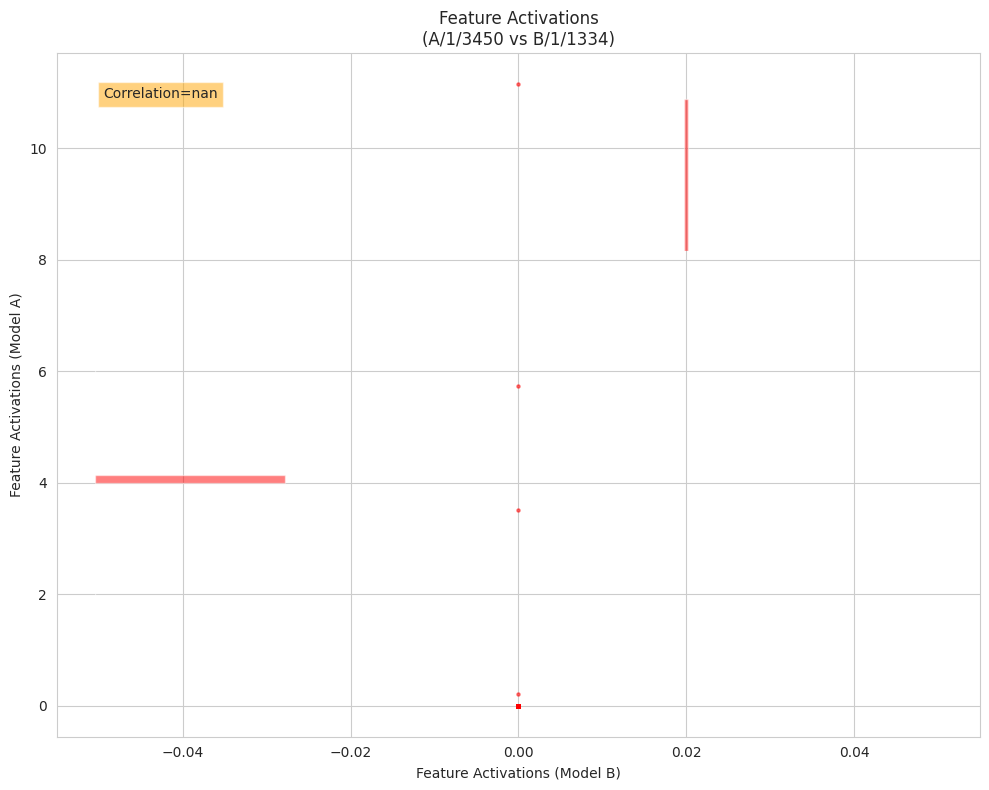

In [ ]:
import matplotlib.pyplot as plt

# Calculate correlation
correlation = np.corrcoef(feature_0_actvs_A, feature_0_actvs_B)[0, 1]

# Create the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(feature_0_actvs_A, feature_0_actvs_B, alpha=0.5, color='red', s=5)

# Set labels and title
plt.xlabel('Feature Activations (Model B)')
plt.ylabel('Feature Activations (Model A)')
plt.title('Feature Activations\n(A/1/3450 vs B/1/1334)')

# Add correlation text
plt.text(0.05, 0.95, f'Correlation={correlation:.2f}',
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='orange', alpha=0.5),
         verticalalignment='top')

# Add histograms on the sides
left, bottom, width, height = [0.68, 0.68, 0.2, 0.2]
ax2 = plt.axes([left, bottom, width, height])
ax2.hist(feature_0_actvs_B, bins=50, orientation='vertical', color='red', alpha=0.5)
ax2.axis('off')

left, bottom, width, height = [0.1, 0.1, 0.2, 0.58]
ax3 = plt.axes([left, bottom, width, height])
ax3.hist(feature_0_actvs_A, bins=50, orientation='horizontal', color='red', alpha=0.5)
ax3.axis('off')

plt.tight_layout()
plt.show()

# only last token of each sample

In [10]:
feature_acts_model_A[:, -1, :].shape

torch.Size([32, 24576])

In [9]:
feature_acts_model_C[:, -1, :].shape

torch.Size([32, 16384])

In [11]:
reshaped_activations_A = feature_acts_model_A[:, -1, :].cpu()
reshaped_activations_B = feature_acts_model_C[:, -1, :].cpu()

In [12]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Transpose the activations to get F vectors of size N and F_2 vectors of size N
actvs1_T = reshaped_activations_A.T  # shape (F, N)
actvs2_T = reshaped_activations_B.T  # shape (F_2, N)

# Calculate cosine similarity between every F vector and every F_2 vector
cosine_sim_matrix = cosine_similarity(actvs1_T, actvs2_T)  # shape (F, F_2)

In [13]:
cosine_sim_matrix.shape

(24576, 16384)

In [14]:
import numpy as np

def find_top_features(cosine_sim_matrix, top_n=3):
    """
    Finds the top N features in B for each feature in A and vice versa.

    Args:
    - cosine_sim_matrix (numpy.ndarray): Cosine similarity matrix of shape (F, F_2)
    - top_n (int): Number of top features to find. Default is 3.

    Returns:
    - top_features_A_to_B (dict): Dictionary where keys are indices of features in A,
                                  and values are lists of indices of top features in B.
    - top_features_B_to_A (dict): Dictionary where keys are indices of features in B,
                                  and values are lists of indices of top features in A.
    """
    F, F_2 = cosine_sim_matrix.shape

    # Find top N features in B for each feature in A
    top_features_A_to_B = {}
    # for i in range(F):
    for i in range(5):
        top_features_A_to_B[i] = np.argsort(cosine_sim_matrix[i])[-top_n:][::-1]

    # Find top N features in A for each feature in B
    top_features_B_to_A = {}
    # for j in range(F_2):
    for j in range(5):
        top_features_B_to_A[j] = np.argsort(cosine_sim_matrix[:, j])[-top_n:][::-1]

    return top_features_A_to_B, top_features_B_to_A

# Find top 3 features
top_features_A_to_B, top_features_B_to_A = find_top_features(cosine_sim_matrix)

print("Top features in B for each feature in A:")
for feature_A, top_features_B in top_features_A_to_B.items():
    print(f"Feature {feature_A} in A: Top features in B - {top_features_B}")

print("\nTop features in A for each feature in B:")
for feature_B, top_features_A in top_features_B_to_A.items():
    print(f"Feature {feature_B} in B: Top features in A - {top_features_A}")


Top features in B for each feature in A:
Feature 0 in A: Top features in B - [16383 16382  5469]
Feature 1 in A: Top features in B - [16383 16382  5469]
Feature 2 in A: Top features in B - [12422 15057  2552]
Feature 3 in A: Top features in B - [16383 16382  5469]
Feature 4 in A: Top features in B - [11483 14203 11418]

Top features in A for each feature in B:
Feature 0 in B: Top features in A - [24575 24574  8185]
Feature 1 in B: Top features in A - [24575 24574  8185]
Feature 2 in B: Top features in A - [24575 24574  8185]
Feature 3 in B: Top features in A - [24575 24574  8185]
Feature 4 in B: Top features in A - [24575 24574  8185]


In [15]:
def find_top_pairs(cosine_sim_matrix, top_n=5):
    """
    Finds the top N pairs of features with the highest cosine similarity.

    Args:
    - cosine_sim_matrix (numpy.ndarray): Cosine similarity matrix of shape (F, F_2)
    - top_n (int): Number of top pairs to find. Default is 5.

    Returns:
    - top_pairs (list of tuples): List of tuples where each tuple contains
                                  (index of feature in A, index of feature in B, cosine similarity value)
    """
    # Flatten the matrix and get the indices of the top N highest values
    flat_indices = np.argsort(cosine_sim_matrix, axis=None)[-top_n:][::-1]

    # Convert flat indices back to 2D indices
    top_pairs = []
    for idx in flat_indices:
        i, j = np.unravel_index(idx, cosine_sim_matrix.shape)
        top_pairs.append((i, j, cosine_sim_matrix[i, j]))

    return top_pairs

# Example usage
N = 10  # batch size
F = 5   # number of features in the first SAE
F_2 = 7 # number of features in the second SAE

# Generate random activations for demonstration purposes
cosine_sim_matrix = np.random.rand(F, F_2)

# Find top 5 pairs
top_pairs = find_top_pairs(cosine_sim_matrix)

print("Top 5 pairs with the highest cosine similarity:")
for feature_A, feature_B, sim in top_pairs:
    print(f"Feature {feature_A} in A and Feature {feature_B} in B: Cosine similarity = {sim}")


Top 5 pairs with the highest cosine similarity:
Feature 3 in A and Feature 1 in B: Cosine similarity = 0.984176500075309
Feature 4 in A and Feature 2 in B: Cosine similarity = 0.958785058848785
Feature 3 in A and Feature 5 in B: Cosine similarity = 0.9126287139092384
Feature 3 in A and Feature 0 in B: Cosine similarity = 0.8724286225320544
Feature 4 in A and Feature 0 in B: Cosine similarity = 0.8618265071067648


In [16]:
# for feature 0

feature_0_actvs_A = reshaped_activations_A[:, 0].numpy()
print(feature_0_actvs_A.shape)
feature_0_actvs_B = reshaped_activations_B[:, 0].numpy()
feature_0_actvs_B.shape

(32,)


(32,)

In [17]:
feature_0_actvs_A

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:
cosine_sim_matrix[0][0]

0.0

In [18]:
np.corrcoef(feature_0_actvs_A, feature_0_actvs_B)

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


array([[nan, nan],
       [nan, nan]])

In [19]:
import torch as t

In [20]:
print("A constant?:", t.all(reshaped_activations_A[:, 0] == reshaped_activations_A[:, 0][0]))
print("B constant?:", t.all(reshaped_activations_B[:, 0] == reshaped_activations_B[:, 0][0]))

A constant?: tensor(True)
B constant?: tensor(True)


<ipython-input-21-8a24ce6a5b59>:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


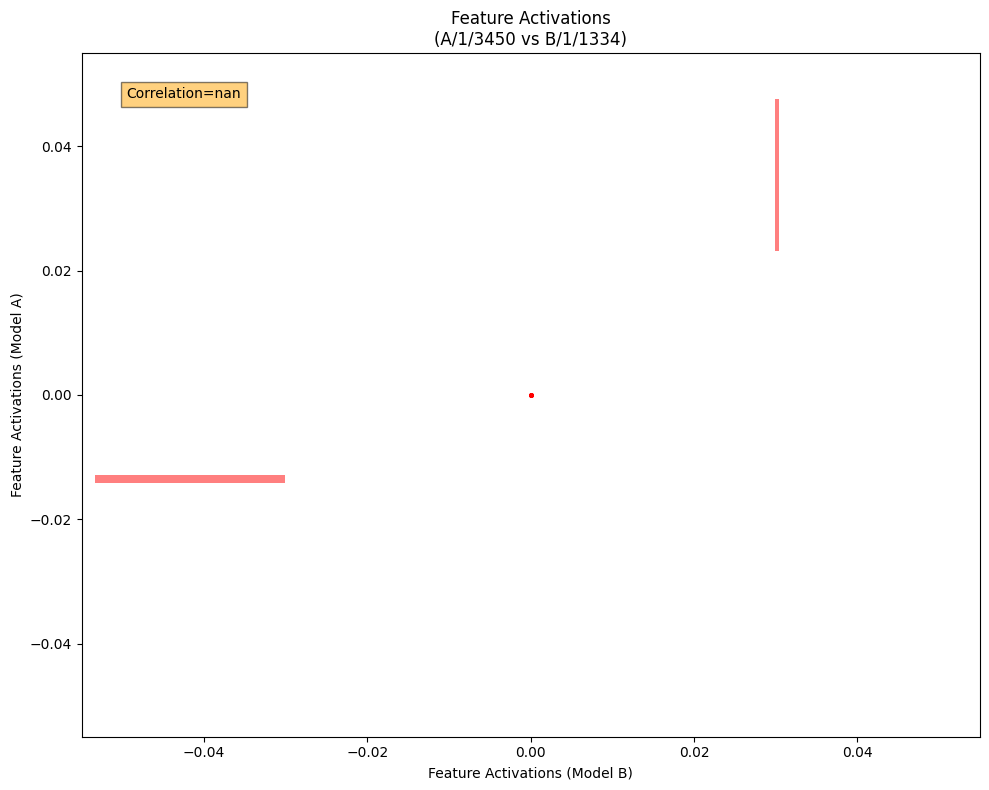

In [21]:
import matplotlib.pyplot as plt

# Calculate correlation
correlation = np.corrcoef(feature_0_actvs_A, feature_0_actvs_B)[0, 1]

# Create the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(feature_0_actvs_A, feature_0_actvs_B, alpha=0.5, color='red', s=5)

# Set labels and title
plt.xlabel('Feature Activations (Model B)')
plt.ylabel('Feature Activations (Model A)')
plt.title('Feature Activations\n(A/1/3450 vs B/1/1334)')

# Add correlation text
plt.text(0.05, 0.95, f'Correlation={correlation:.2f}',
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='orange', alpha=0.5),
         verticalalignment='top')

# Add histograms on the sides
left, bottom, width, height = [0.68, 0.68, 0.2, 0.2]
ax2 = plt.axes([left, bottom, width, height])
ax2.hist(feature_0_actvs_B, bins=50, orientation='vertical', color='red', alpha=0.5)
ax2.axis('off')

left, bottom, width, height = [0.1, 0.1, 0.2, 0.58]
ax3 = plt.axes([left, bottom, width, height])
ax3.hist(feature_0_actvs_A, bins=50, orientation='horizontal', color='red', alpha=0.5)
ax3.axis('off')

plt.tight_layout()
plt.show()